In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load data set

In [2]:
# Cropping and normalization 
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(500),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'data/dataset'
# A map with keys "train" and "val" and values being images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
# A map with keys "train" and "val" and values being DataLoaders. A DataLoader is an iterable. 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize data

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

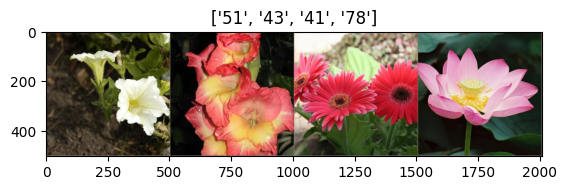

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch for the visualization purposes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Train the model

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_result = []
    accuracy_result = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            batch_index = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                # Move the data to the proper device (GPU or CPU)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                
                # Write the loss and accuracy to list
                loss_result.append([phase, batch_loss, epoch * len(dataloaders[phase]) + batch_index])
                accuracy_result.append([phase, batch_corrects / inputs.size(0), epoch * len(dataloaders[phase]) + batch_index])                
                
                batch_index += 1
            # lr_scheduler provides several methods to adjust the learning rate based on the number of epochs
            if phase == 'train':
                scheduler.step()
                
            # Loss and accuracy of the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)    
    return model, loss_result, accuracy_result

# Visualize the model predictions

In [28]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\n', f'real-class: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Transfer learning the ResNet18

In [11]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features

num_classes = 102
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [21]:
model_ft, loss, accuracy = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 1638/1638 [10:54<00:00,  2.50it/s]


train Loss: 2.3552 Acc: 0.4982


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


valid Loss: 1.3375 Acc: 0.7274

Epoch 1/9
----------


100%|██████████| 1638/1638 [10:51<00:00,  2.51it/s]


train Loss: 1.7586 Acc: 0.6380


100%|██████████| 205/205 [01:13<00:00,  2.79it/s]


valid Loss: 1.0337 Acc: 0.7726

Epoch 2/9
----------


100%|██████████| 1638/1638 [10:38<00:00,  2.56it/s]


train Loss: 1.4139 Acc: 0.7138


100%|██████████| 1638/1638 [10:49<00:00,  2.52it/s]


train Loss: 1.2177 Acc: 0.7561


100%|██████████| 205/205 [01:12<00:00,  2.82it/s]


valid Loss: 0.6404 Acc: 0.8557

Epoch 4/9
----------


100%|██████████| 1638/1638 [10:38<00:00,  2.57it/s]


train Loss: 1.0741 Acc: 0.7720


100%|██████████| 205/205 [01:11<00:00,  2.88it/s]


valid Loss: 0.5766 Acc: 0.8680

Epoch 5/9
----------


100%|██████████| 1638/1638 [10:52<00:00,  2.51it/s]


train Loss: 0.9656 Acc: 0.8001


100%|██████████| 205/205 [01:11<00:00,  2.85it/s]


valid Loss: 0.5507 Acc: 0.8631

Epoch 6/9
----------


100%|██████████| 1638/1638 [10:36<00:00,  2.57it/s]


train Loss: 0.8358 Acc: 0.8414


100%|██████████| 205/205 [01:12<00:00,  2.82it/s]


valid Loss: 0.4701 Acc: 0.8814

Epoch 7/9
----------


100%|██████████| 1638/1638 [10:49<00:00,  2.52it/s]


train Loss: 0.8256 Acc: 0.8486


100%|██████████| 205/205 [01:13<00:00,  2.78it/s]


valid Loss: 0.4444 Acc: 0.8888

Epoch 8/9
----------


100%|██████████| 1638/1638 [10:48<00:00,  2.53it/s]


train Loss: 0.8224 Acc: 0.8478


100%|██████████| 205/205 [01:13<00:00,  2.78it/s]


valid Loss: 0.4420 Acc: 0.8998

Epoch 9/9
----------


100%|██████████| 1638/1638 [10:31<00:00,  2.59it/s]


train Loss: 0.8044 Acc: 0.8564


100%|██████████| 205/205 [01:10<00:00,  2.90it/s]


valid Loss: 0.4607 Acc: 0.8863

Training complete in 119m 35s
Best val Acc: 0.899756


NameError: name 'accuracy' is not defined

AttributeError: 'str' object has no attribute 'items'

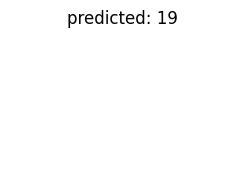

In [29]:
visualize_model(model_ft)